In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
# set random seed for reproductibility
torch.manual_seed(42)

In [3]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [4]:
df.shape

(6000, 785)

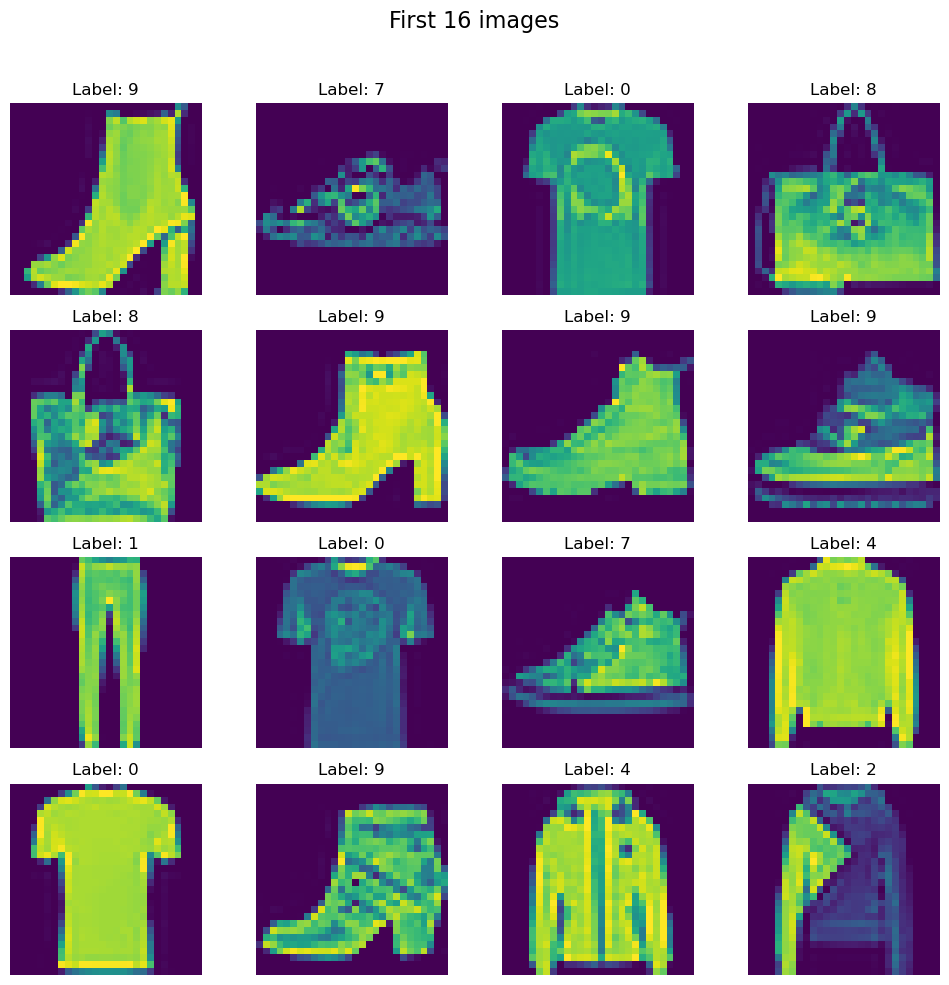

In [5]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4,4, figsize = (10,10))
fig.suptitle('First 16 images', fontsize = 16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28,28) # reshape to 28x28
    ax.imshow(img) # display is grayscale
    ax.axis('off') # remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i,0]}") # show the label
    
plt.tight_layout(rect = [0,0,1,0.96]) # Adjust layout to fit the title
plt.show()

In [6]:
# train_test_split
X = df.iloc[:, 1:].values
y = df.iloc[:,0].values

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size= 0.2)

In [34]:
# scaling the feature
X_train = X_train/255
X_test = X_test/255

In [35]:
# create a CustomDataset class 
class CustomDataset(Dataset):
    
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self,index):
        return self.features[index], self.labels[index]


In [36]:
# create train_dataset object
train_dataset = CustomDataset(X_train,y_train)

In [37]:
len(train_dataset)

4800

In [38]:
#create test_dataset object
test_dataset = CustomDataset(X_test, y_test)


In [39]:
len(test_dataset)

1200

In [40]:
# create train and test loader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False) 
# shuffle = false in test_loader becuase while predicting , we don't want to shuffle our data to correctly calculate accuracy

In [41]:
# define NN class
class MyNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
           nn.Linear(num_features,128),
           nn.ReLU(),
           nn.Linear(128,64),
           nn.ReLU(),
           nn.Linear(64,10) 
           # we won't need to put softmax activation function after output layer,
           # as pytorch has by default implemented softmax in crossentropy loss
        )
        
    def forward(self,x):
        return self.model(x)

In [42]:
# set learning rate and epochs
epochs = 100
learning_rate = 0.1

In [43]:
X_train.shape[1]

784

In [44]:
len(train_dataset)

4800

In [45]:
# instatiate the model
model = MyNN(X_train.shape[1])

# loss function
criterion = nn.CrossEntropyLoss()


# optimizer
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [47]:
# training loop 
for epoch in range(epochs):
    
    total_epoch_loss = 0
    
    for batch_features , batch_labels in train_loader:
        
        # forward pass
        outputs = model(batch_features)
        
        # calculate loss
        loss = criterion(outputs,batch_labels)
        
        # back pass
        optimizer.zero_grad()
        loss.backward()
        
        # update grads
        optimizer.step()
        
        total_epoch_loss = total_epoch_loss + loss.item()
        
    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch : {epoch + 1} and Loss : {avg_loss}')  
    

Epoch : 1 and Loss : 0.0036629715049639345
Epoch : 2 and Loss : 0.005585530982546819
Epoch : 3 and Loss : 0.007672539760339229
Epoch : 4 and Loss : 0.003134370589784036
Epoch : 5 and Loss : 0.002805969958426431
Epoch : 6 and Loss : 0.002497495176018371
Epoch : 7 and Loss : 0.002332448164719002
Epoch : 8 and Loss : 0.002086717688750165
Epoch : 9 and Loss : 0.0024992705829208718
Epoch : 10 and Loss : 0.0018652758031142487
Epoch : 11 and Loss : 0.002072975756236701
Epoch : 12 and Loss : 0.0018092774620163253
Epoch : 13 and Loss : 0.0017133015983563382
Epoch : 14 and Loss : 0.05138338990179667
Epoch : 15 and Loss : 0.0045433599929674525
Epoch : 16 and Loss : 0.0024596240412211048
Epoch : 17 and Loss : 0.002064363937921977
Epoch : 18 and Loss : 0.002166433224241094
Epoch : 19 and Loss : 0.0015104832235374487
Epoch : 20 and Loss : 0.0014504801532408843
Epoch : 21 and Loss : 0.001428968874097336
Epoch : 22 and Loss : 0.0013535192381338372
Epoch : 23 and Loss : 0.0012354684657475445
Epoch : 24

In [48]:
# set the model to evaluate the model
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [51]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
    
    for batch_features, batch_labels in test_loader:
        
        output = model(batch_features)
        
        _, predicted = torch.max(output, 1)
        
        total = total + batch_labels.shape[0]
        
        correct = correct + (predicted == batch_labels).sum().item()
        
print("Accuracy :", correct/total)
        

Accuracy : 0.8458333333333333
